In [33]:
import math
import os
import sys

import meep.adjoint as mpa
import numpy as np
from autograd import grad
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from scipy import signal, special

import meep as mp
import nlopt  # need install nlopt
plt.style.use("seaborn")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
np.random.seed(0)

cur_path = os.getcwd()


/tmp/ipykernel_1229/273969263.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


**init_file**

In [208]:
# init_file
evaluation_histary_files = []
eps_files = []
epses = []
wg_length = 20
wg_eps = 1.96**2 * np.ones(shape=(int(wg_length / 0.02), 12))
for scatter_angle in [0]:
    sub_file = cur_path + "/init_segmented_opt/"
    evaluation_histary_file = sub_file + f"eval_history_seg_init_{scatter_angle}.npy"
    eps_file = sub_file + f"final_eps_seg_init_{scatter_angle}.npy"
    evaluation_histary_files.append(evaluation_histary_file)
    eps = np.load(eps_file)
    epses.append(eps)
    epses.append(wg_eps)
total_eps = np.concatenate(epses, axis=0)

**segmented_angle_opt**

In [51]:
evaluation_histary_files = []
eps_files = []
epses = []
wg_length = 0
wg_eps = 1.96**2 * np.ones(shape=(int(wg_length / 0.02), 12))
for scatter_angle in [-7.5]:
    sub_file = cur_path + "/seg_angle_opt/"
    evaluation_histary_file = sub_file + f"eval_history_seg_angle_{scatter_angle}.npy"
    eps_file = sub_file + f"final_eps_seg_angle_{scatter_angle}.npy"
    evaluation_histary_files.append(evaluation_histary_file)
    eps = np.load(eps_file)
    epses.append(eps)
    epses.append(wg_eps)
total_eps = np.concatenate(epses, axis=0)

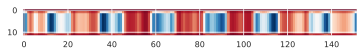

In [52]:
# plot the eps to verify
plt.figure(figsize=(6, 1))
plt.imshow(np.rot90(np.abs(total_eps)), cmap="RdBu")

In [122]:
# plot the evaluation history
# evaluation_history = np.load(evaluation_histary_file)
# plt.plot(evaluation_history)
# print(evaluation_history[-1])

**Basic Setup**

     block, center = (0,-2.1,0)
          size (20.04,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.85,0)
          size (20.04,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.5,0)
          size (20.04,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-5.02,0.25,0)
          size (12,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (7.52,0.25,0)
          size (7,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (2.5,0.25,0)
          size (3.04,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
-----------
Initializing s

time for set_epsilon = 0.591194 s
-----------
MPB solved for frequency_1(0.221208,-1.25453,0) = 1.27389 after 40 iters
     block, center = (0,-2.1,0)
          size (20.04,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0,-0.85,0)
          size (20.04,2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0.5,0)
          size (20.04,0.7,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (-5.02,0.25,0)
          size (12,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block, center = (7.52,0.25,0)
          size (7,0.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8416,3.8416,3.8416)
     block

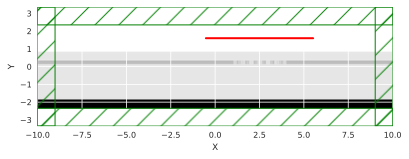

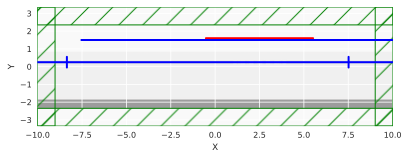

In [53]:
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

##################### length parameter ################
input_wvg_length = 10
output_wvg_length = 5
# design_region
design_region_x = total_eps.shape[0] * grid
design_region_y = 0.2
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1.5
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

plane_y = 0.5 * sy - dpml - 0.5 * near_field_height
plane_x = -0.5 * sx + input_wvg_length + 0.5 * design_region_x + dpml
source_x = design_region_x + 3

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)

####################### geometry ##########################
Substrate_geo = mp.Block(
    material=Si,
    center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
    size=mp.Vector3(sx, Substrate_thickness),
)
BOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml),
    size=mp.Vector3(sx, BOX_thickness),
)
TOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(
        y=-0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * TOX_thickness + dpml
    ),
    size=mp.Vector3(sx, TOX_thickness),
)
input_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        -0.5 * sx + 0.5 * input_wvg_length,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(input_wvg_length + 2 * dpml, h),
)
output_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        0.5 * sx - 0.5 * output_wvg_length,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(output_wvg_length + 2 * dpml, h),
)

geometry = [
    Substrate_geo,
    BOX_geo,
    TOX_geo,
    input_waveguide_geo,
    output_waveguide_geo,
]

####################### geometry ##########################

# ####################### design region ##########################

design_region_resolution_x = resolution
design_region_resolution_y = 5  # 200nm resolution
Nx = int(design_region_resolution_x * design_region_x)
Ny = int(design_region_resolution_y * design_region_y)
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, SiN, grid_type="U_DEFAULT")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(
            -0.5 * sx + input_wvg_length + 0.5 * design_region_x + dpml,
            -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
            0,
        ),
        size=mp.Vector3(design_region_x, design_region_y),
    ),
)
number_para = Nx * Ny
# 初始化granting coupler为最终优化结果
init_para = (np.abs(total_eps[:, 5]) - 1.44**2) / (1.96**2 - 1.44**2)

init_para[init_para > 1] = 1
init_para[init_para < 0] = 0
design_region.update_design_parameters(init_para)
geometry.append(
    mp.Block(
        center=design_region.center,
        size=design_region.size,
        material=design_variables,
    )
)
# ####################### design region ##########################

####################### Sources ##########################
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen
kpoint = mp.Vector3(1, 0, 0)

# # waveguide source
# sources = [
#     mp.EigenModeSource(
#         mp.GaussianSource(frequency=fcen, fwidth=fwidth),
#         center=input_waveguide_geo.center,
#         size=mp.Vector3(0, 3 * h),
#         eig_band=1,
#         eig_parity=mp.EVEN_Y + mp.ODD_Z,
#         eig_match_freq=True,
#         direction=mp.NO_DIRECTION,
#         eig_kpoint=kpoint,
#     )
# ]
# # set nomrlized source: amplitude is 1 -> flux is 1
# sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
#     fcen
# )

rot_angle = -10
# Oblique planewave source
k_point = mp.Vector3(fcen * 1).rotate(mp.Vector3(z=1), np.radians(-(90 + rot_angle)))
sources = [
    mp.EigenModeSource(
        src=mp.GaussianSource(fcen, fwidth=fwidth),
        center=mp.Vector3(plane_x, plane_y),
        size=mp.Vector3(x=source_x),
        direction=mp.NO_DIRECTION,
        eig_kpoint=k_point,
        eig_band=1,
        eig_parity=mp.ODD_Z,
        eig_match_freq=True,
    )
]
sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)


####################### Sources ##########################

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

# ############### Monitor ###################
nfreq = 1

near_region = mp.FluxRegion(
    center=mp.Vector3(plane_x, plane_y - 0.1, 0),
    size=mp.Vector3(sx, 0),
)

near_field = sim.add_mode_monitor(
    fcen,
    0,
    1,
    near_region,
)

# near2far_field
n2f_field = sim.add_near2far(
    fcen,
    0,
    1,
    near_region,
)
near_dft = sim.add_dft_fields(
    [mp.Ez], fcen, fwidth, nfreq, center=near_region.center, size=near_region.size
)

src_region = mp.FluxRegion(
    center=input_waveguide_geo.center - mp.Vector3(input_wvg_length / 3, 0, 0),
    size=mp.Vector3(0, 3 * h, 0),
)
src_field = sim.add_mode_monitor(
    fcen,
    0,
    1,
    src_region,
)

out_region = mp.FluxRegion(
    center=mp.Vector3(output_waveguide_geo.center.x, output_waveguide_geo.center.y, 0),
    size=mp.Vector3(0, 3 * h, 0),
)
out_field = sim.add_mode_monitor(
    fcen,
    0,
    1,
    out_region,
)

wg_region = mp.FluxRegion(
    center=mp.Vector3(0, input_waveguide_geo.center.y, 0),
    size=mp.Vector3(sx, 0),
)
wg_dft = sim.add_dft_fields(
    [mp.Ez], fcen, fwidth, nfreq, center=wg_region.center, size=wg_region.size
)
sim.plot2D(plot_monitors_flag=False)

# mpt = mp.Vector3(input_waveguide_geo.center.x - 3, input_waveguide_geo.center.y)
mpt = mp.Vector3(output_waveguide_geo.center.x - 3, input_waveguide_geo.center.y)

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim.run(
    mp.at_every(1, Animate),
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
)

In [54]:
Animate.to_jshtml(fps=1)

# 远场验证

/tmp/ipykernel_1229/3498950185.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Text(0, 0.5, '$ |{E_z}|^2 $')

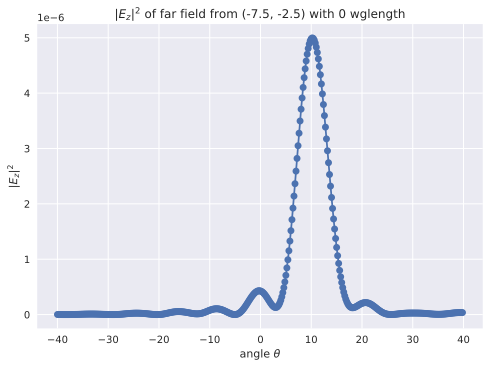

In [55]:
d_angle = 0.2
ff_distance = 1e6
ff_angle = 89
ff_number = int(2 / d_angle * ff_angle) + 1
ff_angles = np.linspace(-ff_angle, ff_angle, ff_number)
ff_points = [
    mp.Vector3(fx, ff_distance, 0) for fx in np.tan(np.radians(ff_angles)) * ff_distance
]

plt.style.use("seaborn")
n2f = []
for point in ff_points:
    ff = sim.get_farfield(n2f_field, point)
    n2f.append(ff)
rel = []  # rel中存储的是far field的强度
for ff in n2f:
    rel.append(np.abs(ff[2]) ** 2)
    # rel.append(np.abs(ff[2]))


plot_angle = 40  # 绘制的角度范围
figure, ax = plt.subplots()
angle_minlim = np.where(ff_angles == -plot_angle)[0][0]
angle_maxlim = np.where(ff_angles == plot_angle)[0][0]
plt.plot(ff_angles[angle_minlim:angle_maxlim], rel[angle_minlim:angle_maxlim], "-o")
plt.title(r"$ |{E_z}|^2 $ of far field from (-7.5, -2.5) with 0 wglength")
ax.set_xlabel(r"angle $ \theta $")
ax.set_ylabel(r"$ |{E_z}|^2 $")

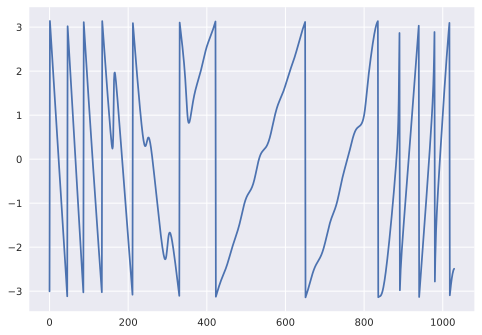

In [42]:
near_field_data = sim.get_dft_array(near_dft, mp.Ez, 0)
plt.plot(np.angle(near_field_data))


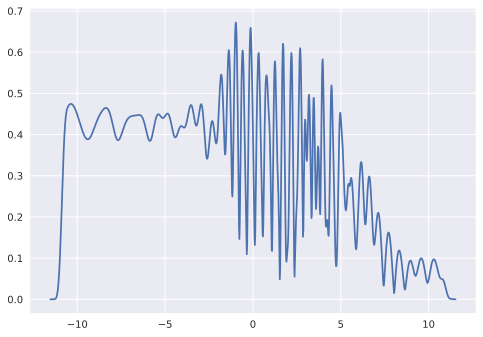

In [43]:
wg_field_data = sim.get_dft_array(wg_dft, mp.Ez, 0)
[x, y, z, w] = sim.get_array_metadata(dft_cell=wg_dft)
plt.plot(x, np.abs(wg_field_data))

In [ ]:
# plot_angle = 40  # 绘制的角度范围
# figure, ax = plt.subplots()
# angle_minlim = np.where(ff_angles == -plot_angle)[0][0]
# angle_maxlim = np.where(ff_angles == plot_angle)[0][0]
# plt.plot(ff_angles[angle_minlim:angle_maxlim], np.abs(n2f_total[angle_minlim:angle_maxlim])**2, "-o")
# plt.title(r"$ |{E_z}|^2 $ of far field")
# ax.set_xlabel(r"angle $ \theta $")
# ax.set_ylabel(r"$ |{E_z}|^2 $")

In [32]:
d_length = []
for angle in ff_angles:
    # The length of each angle in the far field
    length = ff_distance / np.cos(np.radians(angle))
    d_length.append(np.radians(d_angle) * length)

print(f"The total length {np.sum(d_length)} um calculated by angles")

energy = 0
for ii in range(0, ff_number, 1):
    energy = energy + d_length[ii] * (np.abs(rel[ii]))
print(f"The power of near_field is {energy}")

near_field_flux = mp.get_fluxes(near_field)
print(f"The power of near_field is {near_field_flux[0]}")


The total length 9689347.824509013 um calculated by angles
The power of near_field is 0.657015509388351
The power of near_field is 0.6550131408319512


In [18]:
angle0_index = np.where(ff_angles == 0)[0][0]
print(rel[angle0_index]/np.sum(rel))
print((rel[angle0_index]*d_length[angle0_index])/near_field_flux[0])

0.012450676175248242
0.011966553823117912


**mode and flux of input and output**

In [44]:
input_mode = sim.get_eigenmode_coefficients(
    src_field, [1], eig_parity=mp.EVEN_Y + mp.ODD_Z
)
input_mode_coe = np.squeeze(input_mode.alpha)
input_flux = mp.get_fluxes(src_field)
print(f"根据eigenmode_coe[0]计算得到的flux: {abs(input_mode_coe[0]) ** 2}")
print(f"根据flux计算得到的flux: {input_flux}")
print(f'逆向eigenmode_coe[0]: {abs(input_mode_coe[1]) ** 2}')
print(f"正向eigenmode_coe[0]-逆向eigenmode_coe[1]: {abs(input_mode_coe[0]) ** 2 - abs(input_mode_coe[1]) ** 2}")

MPB solved for frequency_1(2.49682,0,0) = 1.43418 after 11 iters
MPB solved for frequency_1(2.18904,0,0) = 1.27235 after 7 iters
MPB solved for frequency_1(2.19192,0,0) = 1.27389 after 5 iters
MPB solved for frequency_1(2.19192,0,0) = 1.27389 after 1 iters
Dominant planewave for band 1: (2.191922,-0.000000,0.000000)
根据eigenmode_coe[0]计算得到的flux: 7.136885294572597e-07
根据flux计算得到的flux: [-0.07612946920359187]
逆向eigenmode_coe[0]: 0.07012709257162783
正向eigenmode_coe[0]-逆向eigenmode_coe[1]: -0.07012637888309838


In [45]:
output_mode = sim.get_eigenmode_coefficients(
    out_field, [1], eig_parity=mp.EVEN_Y + mp.ODD_Z
)
output_mode_coe = np.squeeze(output_mode.alpha)
output_flux = mp.get_fluxes(out_field)
print(output_flux)
print(np.abs(output_mode_coe[0]) ** 2)

MPB solved for frequency_1(2.49682,0,0) = 1.43418 after 11 iters
MPB solved for frequency_1(2.18904,0,0) = 1.27235 after 7 iters
MPB solved for frequency_1(2.19192,0,0) = 1.27389 after 5 iters
MPB solved for frequency_1(2.19192,0,0) = 1.27389 after 1 iters
Dominant planewave for band 1: (2.191922,-0.000000,0.000000)
[0.0039699007915286735]
0.0018917139638095209


In [ ]:
# # plot the eps
# plt.style.use("seaborn-paper")
# eps = np.load(eps_file)
# print(eps.shape)
# f1, ax = plt.subplots(1, 2, figsize=(17, 5))
# ax[0].imshow(np.rot90(np.abs(eps)), cmap="GnBu")
# ax[0].set_title("Final eps")
# ax[1].plot(eps[:, 5], "-o")

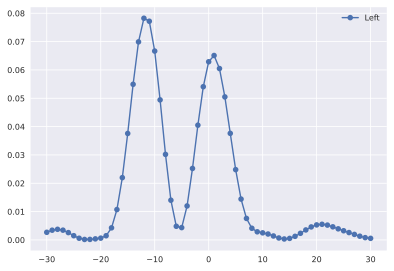

In [49]:
# import simulation results from file 'base_simulation_Gs_back.py'
port_left_fluxes = np.load("port_left_fluxes.npy")
# port_right_fluxes = np.load("port_right_fluxes.npy")
angles = np.load("angles.npy")
plt.plot(angles, np.abs(port_left_fluxes), "-o", label="Left")
# plt.plot(angles, np.abs(port_right_fluxes), "-o", label="Right")
plt.legend()